# Model Prep

In [1]:
# Dependencies
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import math

In [2]:
# Location files
features_loc = "../dataset/time_scored/train_feat.pickle"
target_loc = "../dataset/time_scored/train_target.pickle"

In [3]:
features_df = pd.read_pickle(features_loc)
target_df = pd.read_pickle(target_loc)

## Check for missing values

In [4]:
# Check NA in target df
target_df.isna().sum()
#Only one in PERMA and HAP, look at the row
with pd.option_context('display.max_columns', None):
    display(target_df[target_df["PERMA"].isna()])

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,insta_user_id,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account
4,0a1002b2232a4ecbde604462f6d84bf9,Female,1993,College graduate,A student,"$20,000 to $29,999",7,5,7,4,6,7,7,7,6,7,5,6,2,2,8,2,7,6,6,7,5,8,NaN,Yes,263042348,true,2016-12-05 14:02:36,2016-12-05 14:04:43,aae4bbb89a,5.666667,6.0,6.0,6.666667,7.0,NaN,3.0,5.666667,73.0,public


In [5]:
# Impute hapiness by median of all values 
target_df.loc[target_df["PERMA"].isna(),"HAP"]  = target_df["HAP"].median()

In [6]:
# Create vector for columns of questions
questions = list(target_df.columns[6:29])
questions.remove('LON')
questions = [q for q in questions if q not in ('LON', 'N_1', 'N_2', 'N_3','H_1', 'H_2', 'H_3')]
questions.sort()
print(questions)

['A_1', 'A_2', 'A_3', 'E_1', 'E_2', 'E_3', 'HAP', 'M_1', 'M_2', 'M_3', 'P_1', 'P_2', 'P_3', 'R_1', 'R_2', 'R_3']


In [7]:
# Calculate PERMA score using mean of all questions
target_df.loc[target_df["PERMA"].isna(),"PERMA"] =  target_df.loc[target_df["PERMA"].isna(),
                                                                  questions].mean(axis = 1)
# Check if all individual questions aa up to the PERMA score
(target_df[questions].mean(axis = 1) == target_df["PERMA"]).mean()

1.0

In [9]:
features_df.head()

,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,...,emotion_label_loathing,emotion_label_pensiveness,emotion_label_rage,emotion_label_sadness,emotion_label_serenity,emotion_label_surprise,emotion_label_terror,emotion_label_trust,emotion_label_vigilance,elapsed_time
148,621.06724,636.224211,0.781409,53.0,132.0,97.0,3.048755,0.033649,0.017317,0.003450,...,0.000000,0.002046,0.003981,0.138525,0.083117,0.010394,0.006151,0.014126,0.000000,438.808613
98,612.00000,612.000000,0.737729,35.0,10.0,26.0,9.929340,0.113584,0.009278,0.000000,...,0.000000,0.000000,0.000000,0.176722,0.029617,0.019694,0.007210,0.019185,0.000000,1678.845668
16,640.00000,640.000000,0.730110,55.0,78.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,704.000000
75,632.84184,631.596154,0.816739,349.0,1086.0,947.0,12.382825,0.092649,0.038246,0.033269,...,0.000028,0.000679,0.011839,0.131816,0.021258,0.012125,0.013007,0.022197,0.000028,1160.749747
18,637.58624,639.956766,0.820699,228.0,526.0,779.0,3.281842,0.030701,0.009209,0.005188,...,0.000000,0.000000,0.001851,0.087648,0.022108,0.015484,0.003363,0.012809,0.000000,375.448944


In [10]:
# Check missing values of features
features_df.isnull().sum()

image_height                  0
image_width                   0
data_memorability             0
user_followed_by              0
user_follows                  0
user_posted_photos            0
age                           0
glasses                       0
face_emotion_ANGRY            0
face_emotion_CALM             0
face_emotion_CONFUSED         0
face_emotion_DISGUSTED        0
face_emotion_HAPPY            0
face_emotion_SAD              0
face_emotion_SURPRISED        0
facial_hear                   0
smile                         0
unkown_gender                 0
male                          0
female                        0
anp_sentiment                 0
emotion_score                 0
emotion_label_acceptance      0
emotion_label_admiration      0
emotion_label_amazement       0
emotion_label_anger           0
emotion_label_annoyance       0
emotion_label_anticipation    0
emotion_label_apprehension    0
emotion_label_boredom         0
emotion_label_disgust         0
emotion_

In [11]:
# 11 people did not have any faces in their data. All values will be imputed to 0
features_df = features_df.fillna(0)
features_df.isnull().sum().sum()

0

## Check Histograms

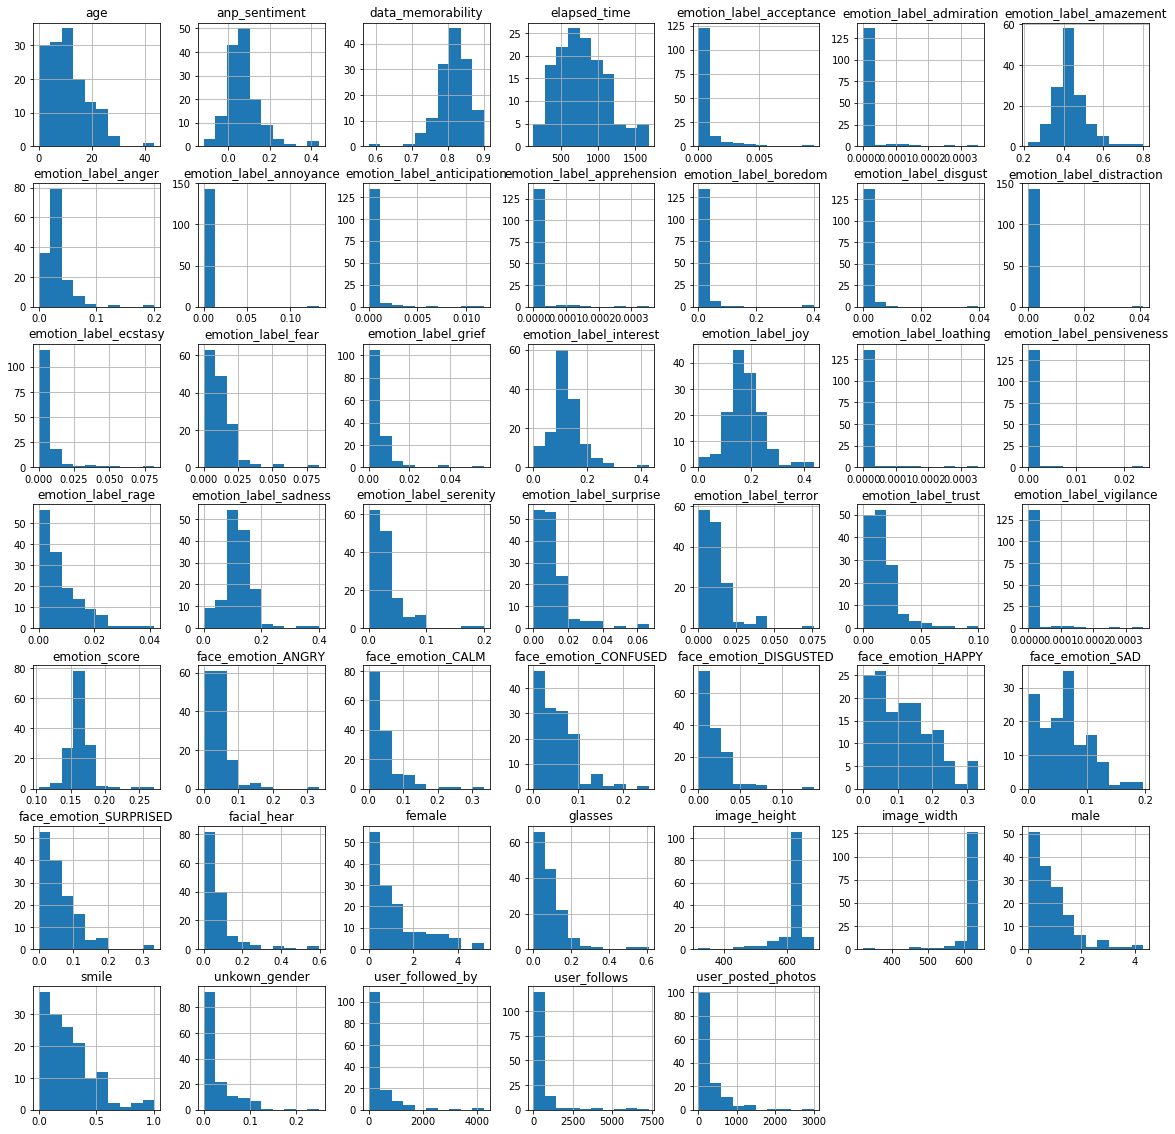

In [12]:
features_df.hist(figsize= (20,20))
plt.show()

In [13]:
# Select all values not equal to 0 to perform log transform
values_to_transform = ["user_followed_by" , "user_follows","user_posted_photos"]
for value in values_to_transform:
    select_log_transform = (features_df.loc[:,[value]] != 0)[value]
    features_df.loc[select_log_transform,[value]] = np.log10(features_df.loc[select_log_transform,[value]])

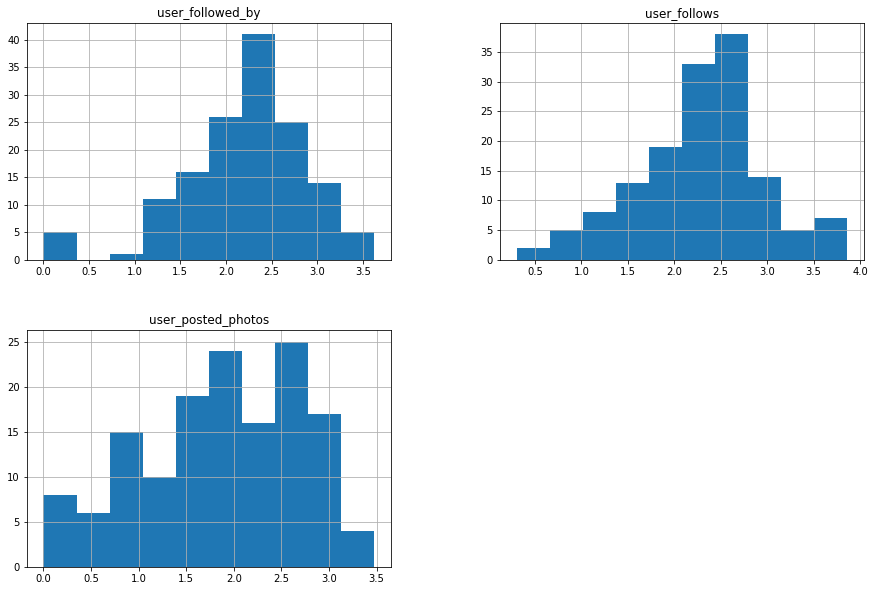

In [14]:
features_df.loc[:,values_to_transform].hist(figsize= (15,10))
plt.show()

## Check correlation of features

In [15]:
corrMatrix = features_df.corr()
corrMatrix.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,face_emotion_CONFUSED,face_emotion_DISGUSTED,face_emotion_HAPPY,face_emotion_SAD,face_emotion_SURPRISED,facial_hear,smile,unkown_gender,male,female,anp_sentiment,emotion_score,emotion_label_acceptance,emotion_label_admiration,emotion_label_amazement,emotion_label_anger,emotion_label_annoyance


In [16]:
corrMatrixspear = features_df.corr(method="spearman")
corrMatrixspear.style.applymap(lambda x: 'color:green' if x > 0.65 else 'color:red')

,image_height,image_width,data_memorability,user_followed_by,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,face_emotion_CONFUSED,face_emotion_DISGUSTED,face_emotion_HAPPY,face_emotion_SAD,face_emotion_SURPRISED,facial_hear,smile,unkown_gender,male,female,anp_sentiment,emotion_score,emotion_label_acceptance,emotion_label_admiration,emotion_label_amazement


In [17]:
# Select combinations of correlated pairs and drop the one that is least correlated with target_df["PERMA"]  
pd.merge(target_df, features_df, on=[target_df.index])[['PERMA', 'image_height', 'image_width', 'user_followed_by', 'user_follows', 'smile', 'face_emotion_HAPPY']].corr().style.applymap(lambda x: 'color:green' if x > 0.6 else 'color:red')

,PERMA,image_height,image_width,user_followed_by,user_follows,smile,face_emotion_HAPPY
PERMA,1,-0.0655219,-0.0554664,-0.0592727,-0.0201063,-0.0323997,-0.0506503
image_height,-0.0655219,1,0.801463,0.25619,0.154378,0.257532,0.280182
image_width,-0.0554664,0.801463,1,0.291069,0.247334,0.104257,0.13653
user_followed_by,-0.0592727,0.25619,0.291069,1,0.772174,-0.0132341,0.0911157
user_follows,-0.0201063,0.154378,0.247334,0.772174,1,-0.0923601,-0.0414056
smile,-0.0323997,0.257532,0.104257,-0.0132341,-0.0923601,1,0.958111
face_emotion_HAPPY,-0.0506503,0.280182,0.13653,0.0911157,-0.0414056,0.958111,1


In [18]:
# we need to drop the lowest correlated combinations of variables
# these are:
# 1. image_height
# 2. user_followed_by
# 3. face_emotion_HAPPY
features_df_cleaned = features_df.copy().drop(["image_height", "user_followed_by", "face_emotion_HAPPY"], axis=1)
features_df_cleaned

,image_width,data_memorability,user_follows,user_posted_photos,age,glasses,face_emotion_ANGRY,face_emotion_CALM,face_emotion_CONFUSED,face_emotion_DISGUSTED,...,emotion_label_loathing,emotion_label_pensiveness,emotion_label_rage,emotion_label_sadness,emotion_label_serenity,emotion_label_surprise,emotion_label_terror,emotion_label_trust,emotion_label_vigilance,elapsed_time
148,636.224211,0.781409,2.120574,1.986772,3.048755,0.033649,0.017317,0.003450,0.011461,0.006749,...,0.000000,0.002046,0.003981,0.138525,0.083117,0.010394,0.006151,0.014126,0.000000,438.808613
98,612.000000,0.737729,1.000000,1.414973,9.929340,0.113584,0.009278,0.000000,0.034877,0.039948,...,0.000000,0.000000,0.000000,0.176722,0.029617,0.019694,0.007210,0.019185,0.000000,1678.845668
16,640.000000,0.730110,1.892095,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,704.000000
75,631.596154,0.816739,3.035830,2.976350,12.382825,0.092649,0.038246,0.033269,0.049260,0.023589,...,0.000028,0.000679,0.011839,0.131816,0.021258,0.012125,0.013007,0.022197,0.000028,1160.749747
18,639.956766,0.820699,2.720986,2.891537,3.281842,0.030701,0.009209,0.005188,0.008020,0.006424,...,0.000000,0.000000,0.001851,0.087648,0.022108,0.015484,0.003363,0.012809,0.000000,375.448944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,625.425314,0.778400,2.127105,2.296665,10.753579,0.157648,0.034018,0.028153,0.053635,0.012290,...,0.000000,0.000000,0.006200,0.129515,0.030613,0.012539,0.010429,0.013583,0.000000,1054.369623
106,632.050657,0.826375,3.712144,2.839478,15.940795,0.124334,0.034365,0.047959,0.066932,0.014847,...,0.000000,0.000000,0.007782,0.107851,0.046835,0.017771,0.011151,0.020987,0.000000,485.973473
14,639.201661,0.785762,2.571709,2.193125,27.807295,0.149009,0.090718,0.085541,0.105482,0.064639,...,0.000000,0.001291,0.006279,0.121248,0.019348,0.006871,0.017556,0.014807,0.000000,665.462449
92,595.230990,0.773050,2.053078,1.176091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.143092,0.092669,0.000000,0.011392,0.038070,0.000000,648.525538


In [19]:
# Save cleaned data
features_df_cleaned.to_pickle('../dataset/time_scored/train_feat_cleaned.pickle')
target_df.to_pickle('../dataset/time_scored/train_target_cleaned.pickle')